In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
import qcgpu

In [3]:
def VCircuit(qubits, parameters, layers):
    if qubits%2==1: raise ValueError('Try even number of qubits')
    C = qcgpu.State(qubits)
    p = 0
    for layer in range(layers):
        for i in range(qubits):
            C.u(i, parameters[p], 0, 0)
            p+=1
        for i in range(0, qubits, 2):
            C.apply_controlled_gate(qcgpu.gate.z(),i, i+1)
        for i in range(qubits):
            C.u(i, parameters[p], 0, 0)
            p+=1
        C.apply_controlled_gate(qcgpu.gate.z(), 0, qubits-1)
        for i in range(1, qubits-1, 2):
            C.apply_controlled_gate(qcgpu.gate.z(), i, i+1)
    for i in range(qubits):
        C.u(i, parameters[p], 0, 0)
        p+=1
    return C

In [4]:
def parameters(qubits, layers):
    num = 2 * qubits * (layers + 1)
    p = 2*pi*np.random.random((num,))
    return p

In [5]:
def HO(x, p, psi, m, w, mu):
    H = ((x-mu)*psi + p/(m*w))**2
    return H

In [6]:
def cost_function(parameters, qubits, layers, m, w, mu, x):
    circ = VCircuit(qubits, parameters, layers)
    cost = 0
    psi = np.real(circ.amplitudes())
    dx = x[1]-x[0]
    p = np.gradient(psi, dx)
    for i in range(2**qubits):
        cost+=HO(x[i], p[i], psi[i], m, w, mu)
    return cost

In [7]:
def result(parameters, qubits, layers, free):
    circ = VCircuit(qubits, parameters, layers)
    psi = circ.amplitudes()
    sol = []
    for i in range(2**qubits):
        sol.append(np.abs(psi[i])**2)
    return np.array(sol)

In [8]:
def gauss(x, mu, sigma):
    dx = x[1]-x[0]
    g = (1/(np.sqrt(2*pi*sigma**2)))*np.exp(-((x-mu)**2)/(2*sigma**2))
    f = g*dx/(np.sum(g * dx))
    return f

In [16]:
def optimize(qubits, layers, m, w, S0, S, meth='COBYLA', to = 1e-10, maxi = 5000):
    para = parameters(qubits, layers)
    solution = minimize(cost_function, para, args=(qubits, layers, m, w, S0, S), method=meth, tol=to, options={'maxiter':maxi})
    return solution.x, cost_function(solution.x, qubits, layers, m, w, S0, S)

In [17]:
from scipy.optimize import minimize

In [18]:
qu = 6
fr = 1
lay = qu
m = 1/2
w = 1
S0 = 5
K = 6
sig = 2*m*w

S = np.linspace(S0-3*sig, S0+3*sig, (2**qu))

g = gauss(S, S0, sig)

In [19]:
optimal_parameters, cost = optimize(qu, lay, m, w, S0, S)

In [20]:
print(cost)

1.3118653534768403


In [21]:
r = result(optimal_parameters, qu, lay, fr)

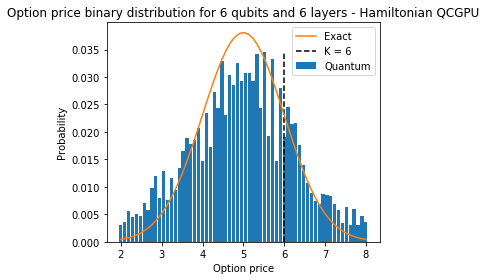

In [22]:
#Plot the probabilities of the circuit against the classical gaussian probabilities
width = (S[1]-S[0])/1.2
fig, ax = plt.subplots()
#rects1 = ax.bar(S-width/2, g, width, label='Exact')
rects2 = ax.bar(S, r, width, label='Quantum')
ax.plot(S, g, 'C1', label='Exact')

ax.vlines(K, 0, max(r), linestyles='dashed', label='K = {}'.format(K))
plt.ylabel('Probability')
plt.xlabel('Option price')
plt.title('Option price binary distribution for {} qubits and {} layers - Hamiltonian QCGPU'.format(qu, lay))
ax.legend()


fig.tight_layout()

plt.savefig('{}qubits{}layers_Hamiltonian_QCGPU.png'.format(qu, lay), bbox_inches='tight')

plt.show()